# RL and Advanced DL: Домашнее задание 1

## Часть первая, с блекджеком и стратегиями
Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:  
* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;  
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;  
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;  
* игрок может совершать одно из двух действий:
 * hit  — взять ещё одну карту;
 * stand — не брать больше карт;  
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
* после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

In [1]:
import numpy as np
import gym
from typing import Tuple, Generator, Any, Callable, Iterable, Dict
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [4]:
STAND, HIT, DOUBLE = 0, 1, 2

In [5]:
def action2str(action: int) -> str:
    if action == STAND:
        return 'Stand'
    if action == HIT:
        return 'Hit'
    if action == DOUBLE:
        return 'Double'
    return 'Unknown'

In [6]:
def state2str(state: Tuple) -> str:
    return f'--\nplayer: {state[0]}\ndealer: {state[1]}\nusable ace: {state[2]}'

In [7]:
def human_readable_observations(observations: Iterable[Tuple]) -> None:
    return '\n'.join([f' {i}\n{state2str(o)}' for i, o in enumerate(observations)])

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [8]:
def simple_policy(observation: Tuple, threshold=19) -> int:
    score, dealer, usable_ace = observation
    if score < threshold:
        return HIT
    return STAND

In [9]:
def simple_fuzzy_policy(observation: Tuple, threshold=19) -> int:
    score, dealer, usable_ace = observation
    p = [0.2, 0.8] if score < threshold else [0.8, 0.2]
    return np.random.choice([STAND, HIT], p=p)

In [10]:
def play_single_game(policy: Callable, verbose: bool = False):
    observation, done = env.reset(), False
    states, actions, rewards = [], [], []
    while not done:
        states.append(observation)
        action = policy(observation=observation)
        actions.append(action)
        observation, reward, done, _ = env.step(action)
        rewards.append(reward)
    if verbose:
        print(human_readable_observations(states))
        print(state2str(observation))
        print(rewards)
        print('--------------')
#     states.append(observation)
    return states, actions, rewards

In [11]:
NUM_GAMES = 10000

In [12]:
def mc_estimation(policy: Callable, num_games: int = NUM_GAMES, verbose: bool = False):
    values = defaultdict(int)
    N = defaultdict(int)
    avg_reward = 0
    moving_avg_rewards = []
    for i in tqdm(range(1, num_games)):
        if verbose:
            print(f'{i}{"-th" if i % 10 > 2 or i % 10 == 0 else ""} episode')
        total_reward_per_episode = 0
        states, actions, rewards = play_single_game(policy, verbose=verbose)
        avg_reward += sum(rewards)
        moving_avg_rewards.append(avg_reward / i)
        for j, (s, r) in reversed(list(enumerate(zip(states, rewards)))):
            # общая награда в этом эпизоде
            total_reward_per_episode += r
            if s not in states[:j]:
                N[s] += 1
                values[s] += (total_reward_per_episode - values[s]) / N[s]
    avg_reward /= num_games
    return values, avg_reward, moving_avg_rewards

In [13]:
def mc_estimation_plot(policies: Iterable[Callable], num_games: int = NUM_GAMES, verbose: bool = False):
    fig, ax = plt.subplots(figsize=(20, 8))
    for policy in policies:
        values, avg_reward, moving_avg_rewards = mc_estimation(policy, num_games, verbose=verbose)
        ax.plot(range(len(moving_avg_rewards)), moving_avg_rewards, lw=2, label=policy.__name__)
        ax.legend()
        print(f'average reward for {policy.__name__} = {avg_reward}')
        yield values, avg_reward

100%|██████████| 9999/9999 [00:00<00:00, 20928.86it/s]


average reward for simple_policy = -0.1992
average reward = -0.1992


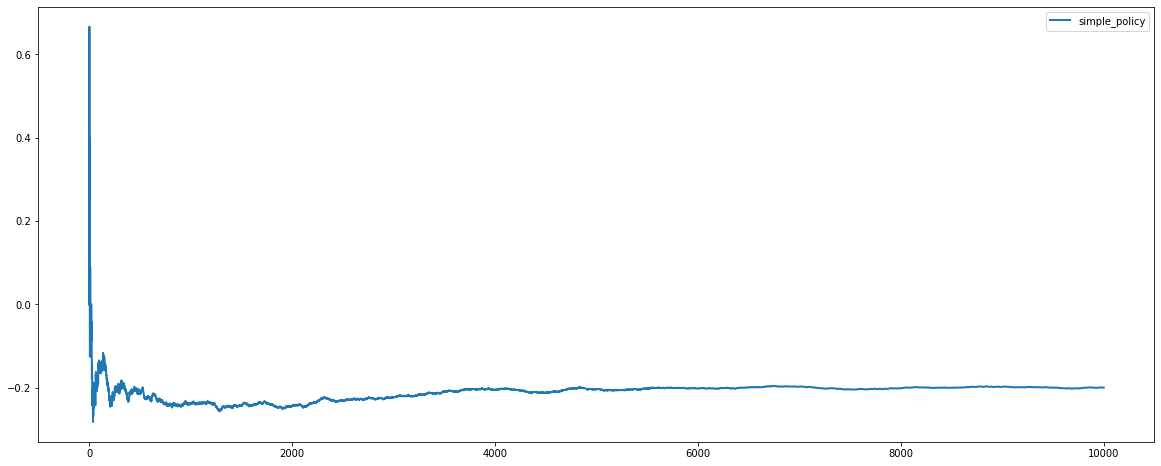

In [14]:
policies = [simple_policy] #, simple_fuzzy_policy]
values = []
for v, avg_reward in mc_estimation_plot(policies=policies, num_games=NUM_GAMES, verbose=False):
    values.append(v)
    print(f'average reward = {avg_reward}')

In [15]:
def plot_values(values):
    canvas = np.zeros((22, 11, 2))
    fig, axs = plt.subplots(1, 2, figsize=(12, 12))
    for key in values:
        i, j, k = key
        canvas[i, j, 1 if k else 0] = values[key]
        
    
    axs[0].set_title('no usable ace')
    axs[0].set_xlabel('dealer')
    axs[0].set_ylabel('player')
    axs[0].imshow(canvas[:, :, 0], aspect='auto')
    
    axs[1].set_title('usable ace')
    axs[1].set_xlabel('dealer')
    axs[1].set_ylabel('player')
    axs[1].imshow(canvas[:, :, 1], aspect='auto')

In [16]:
# for v in values:
#     plot_values(v)

2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [17]:
NUM_GAMES = 100000

In [18]:
def random_policy(observation: Tuple, num_actions=2, **kwargs) -> int:
    return np.random.choice(num_actions, **kwargs)

In [19]:
def play_single_game(policy: Callable, 
                     step: Callable,
                     Q: Dict,
                     eps: float,
                     verbose: bool = False,
                     num_actions=2):
    observation, done = env.reset(), False
    states, actions, rewards = [], [], []
    while not done:
        states.append(observation)
        probs = np.ones(num_actions) / num_actions
        if observation in Q:
            probs *= eps
            probs[np.argmax(Q[observation])] += 1 - eps
        action = policy(observation=observation, 
                        p=probs, 
                        num_actions=num_actions)
        actions.append(action)
        observation, reward, done, _ = step(action)
        rewards.append(reward)
    if verbose:
        print(human_readable_observations(states))
        print(state2str(observation))
        print(rewards)
        print('--------------')
#     states.append(observation)
    return states, actions, rewards
        

In [20]:
# parameters for mc control
EPS_MIN = 0.001
EPS_DECAY = 0.9
GAMMA = 0.5
ALPHA = 0.1
# seem as tuned well

In [21]:
def mc_control(num_games: int = NUM_GAMES,
               step=env.step,
               verbose: bool = False,
               num_actions=2):
    
    eps = 1.0
    Q = defaultdict(lambda: np.zeros(num_actions))
    avg_reward = 0
    moving_avg_reward = []
    for i in tqdm(range(1, num_games)):
        eps = max(eps * EPS_DECAY, EPS_MIN)
        s, a, r = play_single_game(policy=random_policy,
                                   step=step,
                                   Q=Q,
                                   eps=eps,
                                   verbose=verbose,
                                   num_actions=num_actions)
        avg_reward += sum(r)
        moving_avg_reward.append(avg_reward / i)
        # Q
        for j, (ts, ta, tr) in enumerate(zip(s, a, r)):
            # total reward from selected state (ts)
            total = sum([r[k] * GAMMA ** (k) for k in range(j, len(r))])
            # update Q(state, action)
            Q[ts][ta] += ALPHA * (total - Q[ts][ta])
    # once we've done, just return policy with best reward (Q-value) on each state
    policy = {k: np.argmax(v) for k, v in Q.items()}
    avg_reward /= num_games
    return Q, policy, avg_reward, moving_avg_reward

In [22]:
Q, policy, avg_reward, moving_avg_rewards = mc_control(num_games=NUM_GAMES)

100%|██████████| 99999/99999 [00:15<00:00, 6609.44it/s]


3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

average reward: -0.07451


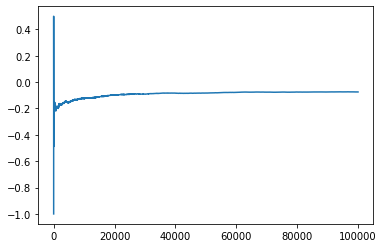

In [23]:
print(f'average reward: {avg_reward}')
plt.plot(range(len(moving_avg_rewards)), moving_avg_rewards)

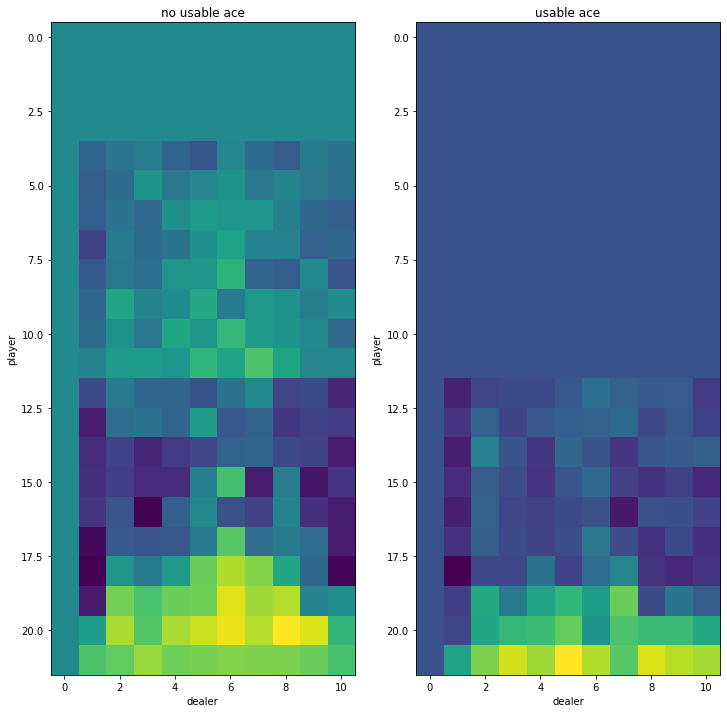

In [24]:
plot_values({k: max(v) for k, v in Q.items()})

## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
 * double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [25]:
def step_with_double(action: int):
    if action == DOUBLE:
        observation, reward, done, info = env.step(HIT)
        return observation, reward * 2, True, info
    else:
        return env.step(action)

5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [26]:
NUM_GAMES=300000

In [27]:
# parameters for mc control
EPS_MIN = 0.01
EPS_DECAY = 0.99
GAMMA = 0.99
ALPHA = 0.02
# seem tuned well, but not sure

In [28]:
Q, policy, avg_reward, moving_avg_rewards = mc_control(num_games=NUM_GAMES,
                                                       num_actions=3,
                                                       step=step_with_double)

100%|██████████| 299999/299999 [00:35<00:00, 8519.39it/s]


average reward = -0.05407666666666667


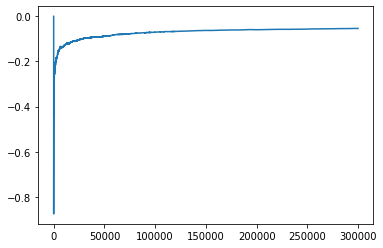

In [29]:
print(f'average reward = {avg_reward}')
plt.plot(range(len(moving_avg_rewards)), moving_avg_rewards)

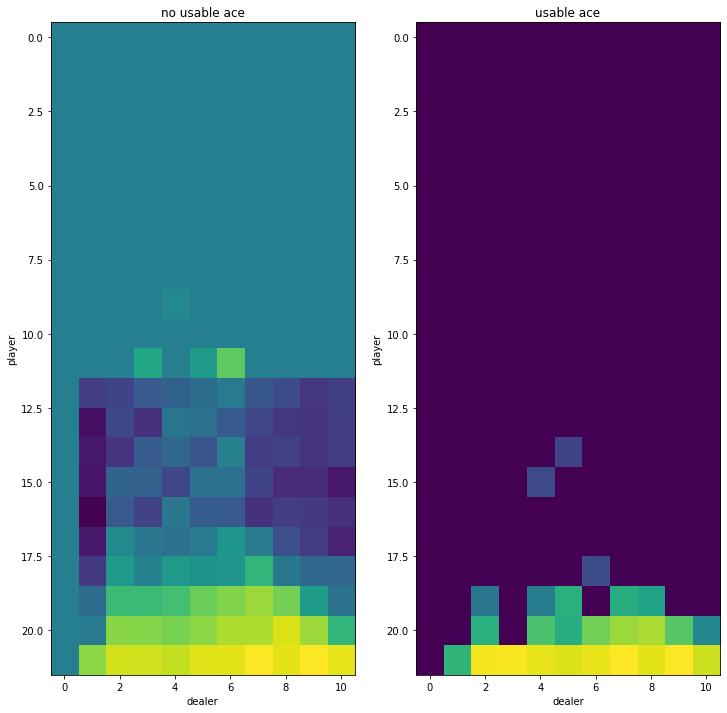

In [30]:
plot_values({k: max(v) for k, v in Q.items()})

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.  
Думаю, у вас уже возникла в голове эта картинка:  

![title](rainman.png)

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет [статья википедии о блекджеке](https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA) (а возможно, и нет).

In [31]:
# not implemented yet

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [32]:
# not implemented yet

## Часть четвёртая, опциональная
Ну и напоследок ещё парочка опциональных заданий за дополнительные баллы.

8. Реализуйте поиск стратегии в блекджеке с известной моделью из первой части, решив уравнения Беллмана для V* или Q*. Для этого вам придётся сначала оценить параметры модели, т.е. найти или обучить вероятности переходов между состояниями.

In [33]:
# not implemented yet

9. Реализуйте вариант из второй или третьей части, в котором есть ещё возможность делать split: в случае, когда игроку пришли две одинаковые карты, он может разбить руку на две, внести ещё одну ставку и продолжать играть две руки сразу (как будто за двоих игроков). Скорее всего, обыграть казино получится только в варианте с разрешённым split’ом и подсчётом карт; если получится, это будет отличное завершение проекта!

In [34]:
# not implemented yet